In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix

#### Preprocessing the data:

In [2]:
training_data = pd.read_csv('train_2024.csv', quoting = 3)   # id, text and label
comments_train = np.array( training_data['text'] )
labels_train = np.array( training_data['label'] )

valid_data = pd.read_csv('dev_2024.csv', quoting = 3)   # id, text and label
comments_valid = np.array( valid_data['text'] )
labels_valid = np.array( valid_data['label'] )

#### Computing the features of the training, validation and test data:

In [3]:
vectorizer = TfidfVectorizer(stop_words = 'english')
matrix_train = vectorizer.fit_transform(comments_train)
matrix_train = matrix_train.transpose()

matrix_valid = vectorizer.fit_transform(comments_valid)
matrix_valid = matrix_valid.transpose()

n_topics = 250
tf_idf_svd = TruncatedSVD(n_components = n_topics)
matrix_train_dense = tf_idf_svd.fit_transform(matrix_train.T).T
matrix_valid_dense = tf_idf_svd.fit_transform(matrix_valid.T).T

#### Gathering the features in panda DataFrames:

In [4]:
pd_train = pd.DataFrame(columns = range(n_topics), index = range(len(comments_train)))
for i in range(len(comments_train)):
    pd_train.loc[i] = matrix_train_dense[:,i]
    
pd_valid = pd.DataFrame(columns = range(n_topics), index = range(len(comments_valid)))
for i in range(len(comments_valid)):
    pd_valid.loc[i] = matrix_valid_dense[:,i]

#### Random Forest:

In [5]:
rf = RandomForestClassifier(criterion = 'log_loss', random_state = 0)
rf.fit(pd_train, labels_train)
pickle.dump(rf, open('RandomForest_model.pkl','wb'))

#### Evaluating the model:

In [6]:
rf_labels_prediction = rf.predict(pd_valid)
rf_precision = precision_score(labels_valid, rf_labels_prediction)
rf_accuracy = accuracy_score(labels_valid, rf_labels_prediction)
rf_f1 = f1_score(labels_valid, rf_labels_prediction)

print('Precision: ', rf_precision)
print('Accuracy: ', rf_accuracy)
print('F1 score: ', rf_f1)

Precision:  0.5242597661109729
Accuracy:  0.6558181818181819
F1 score:  0.52675


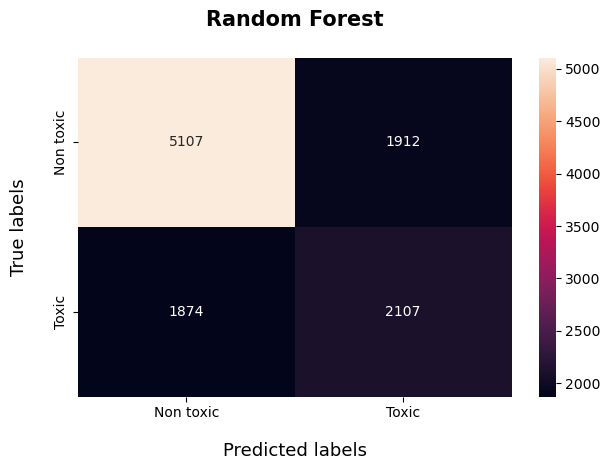

In [7]:
fig, ax = plt.subplots(1, 1)

conf_mat = confusion_matrix(labels_valid, rf_labels_prediction)
sns.heatmap(conf_mat, annot = True, fmt = 'g', ax = ax)
ax.set_xlabel('Predicted labels', fontsize = 13)
ax.set_ylabel('True labels\n', fontsize = 13)
ax.set_title('Random Forest\n', fontsize = 15, weight = 'bold')
ax.xaxis.set_ticklabels(['Non toxic', 'Toxic\n'], fontsize = 10)
ax.yaxis.set_ticklabels(['Non toxic', 'Toxic'], fontsize = 10)

fig.tight_layout()

#### Feeding the model with the test data:

In [8]:
test_data = pd.read_csv('test_2024.csv', quoting = 3)   # id, text and label
comments_test = np.array( test_data['text'] )

matrix_test = vectorizer.fit_transform(comments_test)
matrix_test = matrix_test.transpose()
matrix_test_dense = tf_idf_svd.fit_transform(matrix_test.T).T

pd_test = pd.DataFrame(columns = range(n_topics), index = range(len(comments_test)))
for i in range(len(comments_test)):
    pd_test.loc[i] = matrix_test_dense[:,i]

preds = rf.predict(pd_test)
results = test_data
results = results.drop(['text','label'], axis=1)
results.insert(1,'label',preds)
results.to_csv('results_RF.csv', index = False)

#### Multilayer Perceptron Classifier:

In [33]:
mlp = MLPClassifier(hidden_layer_sizes = 1000, max_iter = 300)
mlp.fit(pd_train, labels_train)
pickle.dump(mlp, open('MLPClassifier_model.pkl','wb'))

#### Evaluating the model:

In [34]:
mlp_labels_prediction = mlp.predict(pd_valid)
mlp_precision = precision_score(labels_valid, mlp_labels_prediction)
mlp_accuracy = accuracy_score(labels_valid, mlp_labels_prediction)
mlp_f1 = f1_score(labels_valid, mlp_labels_prediction)

print('Precision: ', mlp_precision)
print('Accuracy: ', mlp_accuracy)
print('F1 score: ', mlp_f1)

Precision:  0.4150667779632721
Accuracy:  0.5640909090909091
F1 score:  0.4534366807249515


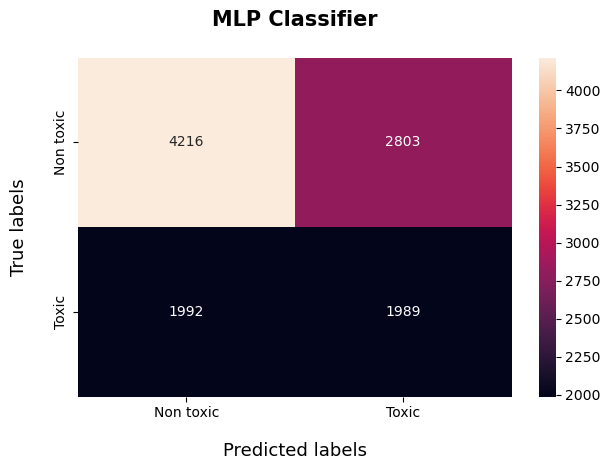

In [35]:
fig, ax = plt.subplots(1, 1)

conf_mat = confusion_matrix(labels_valid, mlp_labels_prediction)
sns.heatmap(conf_mat, annot = True, fmt = 'g', ax = ax)
ax.set_xlabel('Predicted labels', fontsize = 13)
ax.set_ylabel('True labels\n', fontsize = 13)
ax.set_title('MLP Classifier\n', fontsize = 15, weight = 'bold')
ax.xaxis.set_ticklabels(['Non toxic', 'Toxic\n'], fontsize = 10)
ax.yaxis.set_ticklabels(['Non toxic', 'Toxic'], fontsize = 10)

fig.tight_layout()

#### Feeding the model with the test data:

In [ ]:
preds = mlp.predict(pd_test)
results = test_data
results = results.drop(['text','label'], axis=1)
results.insert(1,'label',preds)
results.to_csv('results_MLP.csv', index = False)